In [60]:
import torch
import torch_directml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')
device = torch_directml.device() # parece que com isso ele usa a gpu, mas a velocidade do treinamento não tá incrível

In [61]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [62]:
iris = load_iris()
X = iris.data
y = iris.target
names = iris.target_names
feature_names = iris.feature_names

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2) # 80% para treinamento e 20% para teste

## Informações sobre o dataset

média = [5.84333333 3.05733333 3.758      1.19933333]
desvio = [0.82530129 0.43441097 1.75940407 0.75969263]
moda = [5.8  3.   4.35 1.3 ]


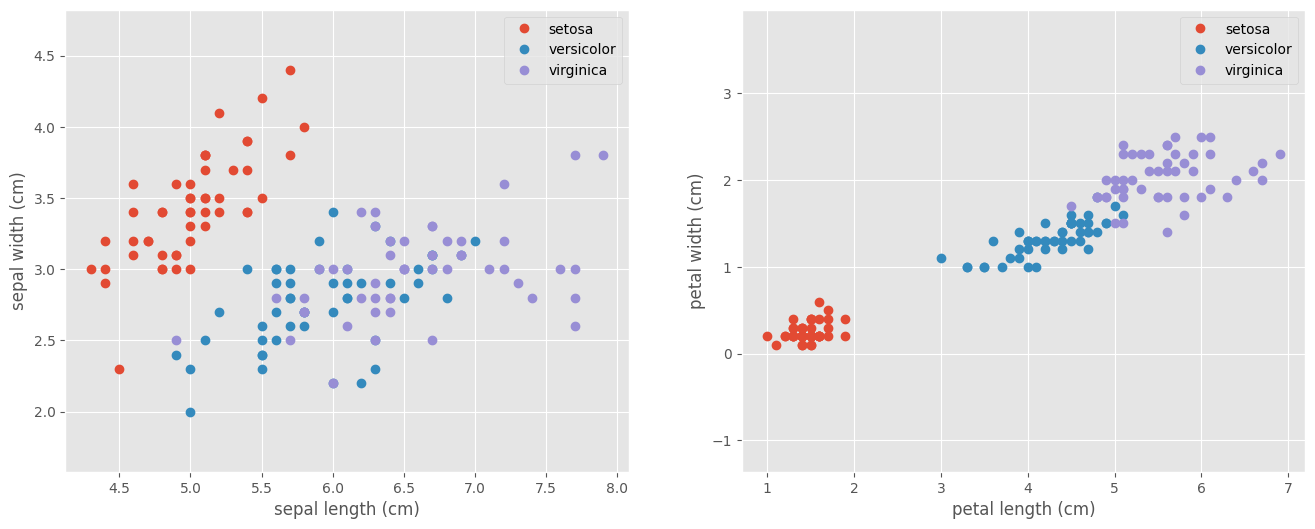

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
median = np.median(X, axis=0)
print(f"média = {mean}\ndesvio = {std}\nmoda = {median}")


## Classificando com Rede Neural

Tentando usar GPU pra isso, mas parece estar bugado

In [64]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [65]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [66]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

### Treinando o Modelo com 100 épocas

In [67]:
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

# tentando usar gpu
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0.3311, 0.3791, 0.2897],
        [0.3692, 0.3719, 0.2589],
        [0.3782, 0.3176, 0.3042],
        [0.4047, 0.3389, 0.2563],
        [0.3267, 0.3741, 0.2993],
        [0.3775, 0.3294, 0.2932],
        [0.3982, 0.3468, 0.2550],
        [0.3587, 0.3706, 0.2707],
        [0.3244, 0.3903, 0.2853],
        [0.3701, 0.3133, 0.3166],
        [0.3667, 0.3067, 0.3267],
        [0.4174, 0.3103, 0.2723],
        [0.3344, 0.3767, 0.2890],
        [0.3777, 0.3504, 0.2720],
        [0.3641, 0.3779, 0.2580],
        [0.3423, 0.3914, 0.2662],
        [0.3647, 0.3660, 0.2694],
        [0.3446, 0.3700, 0.2854],
        [0.3755, 0.3160, 0.3085],
        [0.3275, 0.3900, 0.2825],
        [0.3669, 0.3704, 0.2627],
        [0.3403, 0.3901, 0.2695],
        [0.3841, 0.3213, 0.2945],
        [0.3796, 0.3215, 0.2989],
        [0.3610, 0.3737, 0.2653],
        [0.3996, 0.3559, 0.2445],
        [0.3436, 0.3842, 0.2722],
        [0.3697, 0.3664, 0.2639],
        [0.3535, 0.3893, 0.2572],
        [0.398

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Bool

precisao na ultima época = 0.9000


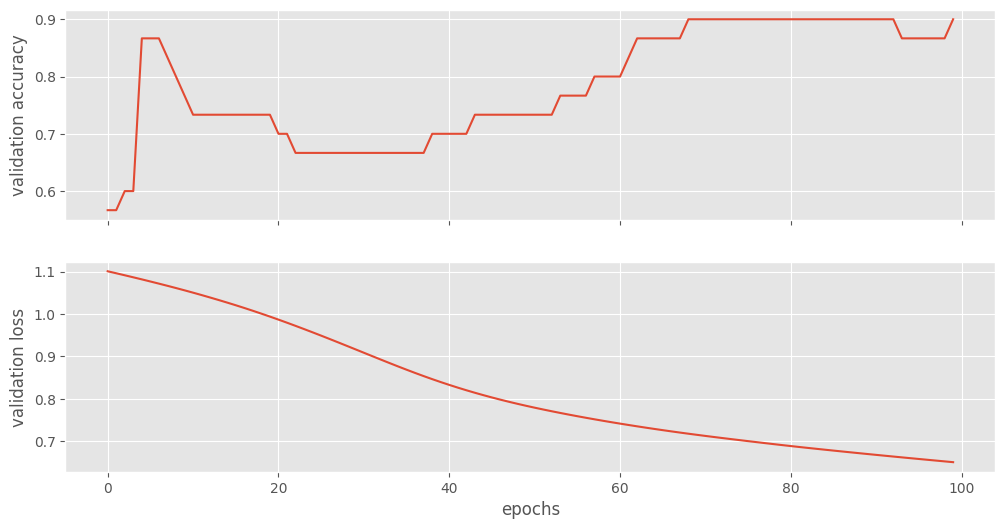

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
print(f"precisao na ultima época = {accuracy_list[-1]:.4f}")

## Classificando com KNN (n=3)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Instantiate learning model (k = 3)
classifier = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"precisao = {accuracy:.4f}")

precisao = 0.9333


Praticamente o mesmo resultado pra KNN e ML, ou seja, nem precisava do pytorch 😭